In [1]:
from sklearn.cluster import KMeans
import numpy as np
import csv
import math
import matplotlib.pyplot
from matplotlib import pyplot as plt

In [71]:
maxAcc = 0.0
maxIter = 0
C_Lambda = 0.003
TrainingPercent = 80
ValidationPercent = 10
TestPercent = 10
M = 10
PHI = []
IsSynthetic = False

In [72]:
def GetTargetVector(filePath):
    t = []
    with open(filePath, 'rU') as f:
        reader = csv.reader(f)
        for row in reader:  
            t.append(int(row[0]))
   
    return t

def GenerateRawData(filePath, IsSynthetic):    
    dataMatrix = [] 
    with open(filePath, 'rU') as fi:
        reader = csv.reader(fi)
        for row in reader:
            dataRow = []
            for column in row:
                dataRow.append(float(column))
            dataMatrix.append(dataRow)   
    
    if IsSynthetic == False :
        dataMatrix = np.delete(dataMatrix, [5,6,7,8,9], axis=1) #since the these columns in the raw data contain zeroes making
                                                                #the matrix singular.
    dataMatrix = np.transpose(dataMatrix)                       
    print ("Data Matrix's TRANSPOSE Generated..", dataMatrix)
    
    return dataMatrix #This is the transpose of the original data so if we ever use GenerateRawData we would need to transpose it.
    

def GenerateTrainingTarget(rawTraining,TrainingPercent = 80):
    TrainingLen = int(math.ceil(len(rawTraining)*(TrainingPercent*0.01)))
    t           = rawTraining[:TrainingLen]
    #print(str(TrainingPercent) + "% Training Target Generated..")
    return t

def GenerateTrainingDataMatrix(rawData, TrainingPercent = 80):
    T_len = int(math.ceil(len(rawData[0])*0.01*TrainingPercent))
    d2 = rawData[:,0:T_len]
    #print(str(TrainingPercent) + "% Training Data Generated..")
    return d2

def GenerateValData(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData[0])*ValPercent*0.01))
    V_End = TrainingCount + valSize
    dataMatrix = rawData[:,TrainingCount+1:V_End]
    #print (str(ValPercent) + "% Val Data Generated..")  
    return dataMatrix

def GenerateValTargetVector(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData)*ValPercent*0.01)) 
    V_End = TrainingCount + valSize
    t =rawData[TrainingCount+1:V_End]
    #print (str(ValPercent) + "% Val Target Data Generated..")
    return t

def GenerateBigSigma(Data, MuMatrix,TrainingPercent,IsSynthetic):
    BigSigma    = np.zeros((len(Data),len(Data)))
    DataT       = np.transpose(Data)   #since "Data" contains transpose of out original data. this step makes the matrix 69623x41
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))  #for training this comes out to be ceil(69623*0.8)=55699      
    varVect     = []
    for i in range(0,len(DataT[0])):    #0~41
        vct = []
        for j in range(0,int(TrainingLen)):  #0~55699
            vct.append(Data[i][j])    
        varVect.append(np.var(vct))
    
    for j in range(len(Data)): #0~41
        BigSigma[j][j] = varVect[j]   
    if IsSynthetic == True:
        BigSigma = np.dot(3,BigSigma)
    else:
        BigSigma = np.dot(200,BigSigma)
    ##print ("BigSigma Generated..")
    print(BigSigma)
    return BigSigma

def GetScalar(DataRow,MuRow, BigSigInv):  
    R = np.subtract(DataRow,MuRow)
    T = np.dot(BigSigInv,np.transpose(R))  
    L = np.dot(R,T)
    
    return L

def GetRadialBasisOut(DataRow,MuRow, BigSigInv):    
    phi_x = math.exp(-0.5*GetScalar(DataRow,MuRow,BigSigInv))
    return phi_x

def GetPhiMatrix(Data, MuMatrix, BigSigma, TrainingPercent = 80):
    DataT = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))         
    PHI = np.zeros((int(TrainingLen),len(MuMatrix))) 
    BigSigInv = np.linalg.inv(BigSigma)             #
    for  C in range(0,len(MuMatrix)):
        for R in range(0,int(TrainingLen)):
            PHI[R][C] = GetRadialBasisOut(DataT[R], MuMatrix[C], BigSigInv) #design matrix 
    #print ("PHI Generated..")
    return PHI

def GetWeightsClosedForm(PHI, T, Lambda):
    Lambda_I = np.identity(len(PHI[0]))
    for i in range(0,len(PHI[0])):
        Lambda_I[i][i] = Lambda
    PHI_T       = np.transpose(PHI)
    PHI_SQR     = np.dot(PHI_T,PHI)
    PHI_SQR_LI  = np.add(Lambda_I,PHI_SQR)
    PHI_SQR_INV = np.linalg.inv(PHI_SQR_LI)
    INTER       = np.dot(PHI_SQR_INV, PHI_T)
    W           = np.dot(INTER, T)
    ##print ("Training Weights Generated..")
    return W

def GetPhiMatrix(Data, MuMatrix, BigSigma, TrainingPercent = 80):
    DataT = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))         
    PHI = np.zeros((int(TrainingLen),len(MuMatrix))) 
    BigSigInv = np.linalg.inv(BigSigma)

    for  C in range(0,len(MuMatrix)):  #length of Mu matrix is 10, because it has M(=10 default setting in program) rows of 41 columns each by default 
        for R in range(0,int(TrainingLen)):
            PHI[R][C] = GetRadialBasisOut(DataT[R], MuMatrix[C], BigSigInv) #number of columns in design matrix phi=number of clusters obtained 
                                                                            #using K means algorithm
        #number of rows of design matrix = length of dataset or the number of inputs which is 55699 is case of trainig dataset since we 
        #have 55699 rows.
    #print ("PHI Generated..")
    return PHI

def GetValTest(VAL_PHI,W):
    Y = np.dot(W,np.transpose(VAL_PHI))
    ##print ("Test Out Generated..")
    return Y

def GetErms(VAL_TEST_OUT,ValDataAct):
    sum = 0.0
    t=0
    accuracy = 0.0
    counter = 0
    val = 0.0
    for i in range (0,len(VAL_TEST_OUT)):
        sum += ((ValDataAct[i] - VAL_TEST_OUT[i])**2)
        if(int(np.around(VAL_TEST_OUT[i], 0)) == ValDataAct[i]):
            counter+=1             #number of correct outputs generated by the model over the dataset.
    accuracy = (float((counter*100))/float(len(VAL_TEST_OUT)))
    ##print ("Accuracy Generated..")
    ##print ("Validation E_RMS : " + str(math.sqrt(sum/len(VAL_TEST_OUT))))
    return (str(accuracy) + ',' +  str(math.sqrt(sum/len(VAL_TEST_OUT))))

## Fetch and Prepare Dataset

In [73]:
RawTarget = GetTargetVector('Querylevelnorm_t.csv')
RawData   = GenerateRawData('Querylevelnorm_X.csv',IsSynthetic)

C:\Users\MAYANK\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 'U' mode is deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\MAYANK\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: 'U' mode is deprecated
  if sys.path[0] == '':


Data Matrix's TRANSPOSE Generated.. [[0.       0.03131  0.078682 ... 0.89793  1.       0.79199 ]
 [0.       0.66667  0.16667  ... 0.33333  1.       0.33333 ]
 [0.       0.5      0.5      ... 0.       0.       0.      ]
 ...
 [0.       0.33333  0.83333  ... 0.30769  0.15385  0.30769 ]
 [0.       0.44828  0.67816  ... 0.26897  0.15862  0.25517 ]
 [0.       0.       0.       ... 0.       0.       0.      ]]


## Prepare Training Data

In [74]:
TrainingTarget = np.array(GenerateTrainingTarget(RawTarget,TrainingPercent))
TrainingData   = GenerateTrainingDataMatrix(RawData,TrainingPercent)
print(TrainingTarget.shape)
print(TrainingData.shape)

(55699,)
(41, 55699)


## Prepare Validation Data

In [75]:
ValDataAct = np.array(GenerateValTargetVector(RawTarget,ValidationPercent, (len(TrainingTarget))))
ValData    = GenerateValData(RawData,ValidationPercent, (len(TrainingTarget)))
print(ValDataAct.shape)
print(ValData.shape)

(6962,)
(41, 6962)


## Prepare Test Data

In [76]:
TestDataAct = np.array(GenerateValTargetVector(RawTarget,TestPercent, (len(TrainingTarget)+len(ValDataAct))))
TestData = GenerateValData(RawData,TestPercent, (len(TrainingTarget)+len(ValDataAct)))
print(ValDataAct.shape)
print(ValData.shape)

(6962,)
(41, 6962)


## Closed Form Solution [Finding Weights using Moore- Penrose pseudo- Inverse Matrix]

In [77]:
ErmsArr = []
AccuracyArr = []

kmeans = KMeans(n_clusters=M, random_state=0).fit(np.transpose(TrainingData)) #clustering data using k means
Mu = kmeans.cluster_centers_
BigSigma     = GenerateBigSigma(RawData, Mu, TrainingPercent,IsSynthetic)
TRAINING_PHI = GetPhiMatrix(RawData, Mu, BigSigma, TrainingPercent) #Mu is a matrix with 41 mean values for each cluster.
W            = GetWeightsClosedForm(TRAINING_PHI,TrainingTarget,(C_Lambda)) 
TEST_PHI     = GetPhiMatrix(TestData, Mu, BigSigma, 100) 
VAL_PHI      = GetPhiMatrix(ValData, Mu, BigSigma, 100)

[[1.10140157e+01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.30326118e+01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.33558239e+01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.41323671e+01
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  1.23814043e+01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 3.59066427e-03]]


In [78]:
print(Mu.shape)
print(BigSigma.shape)
print(TRAINING_PHI.shape)
print(W.shape)
print(VAL_PHI.shape)
print(TEST_PHI.shape)

(10, 41)
(41, 41)
(55699, 10)
(10,)
(6962, 10)
(6961, 10)


## Finding Erms on training, validation and test set 

In [79]:
TR_TEST_OUT  = GetValTest(TRAINING_PHI,W)
VAL_TEST_OUT = GetValTest(VAL_PHI,W)
TEST_OUT     = GetValTest(TEST_PHI,W)

TrainingAccuracy   = str(GetErms(TR_TEST_OUT,TrainingTarget))
ValidationAccuracy = str(GetErms(VAL_TEST_OUT,ValDataAct))
TestAccuracy       = str(GetErms(TEST_OUT,TestDataAct))

In [80]:
print ('UBITname      = Mayank Kulshrestha')
print ('-------------------')
#print ('Person Number = ')
print ('----------------------------------------------------')
print ("------------------LeToR Data------------------------")
print ('----------------------------------------------------')
print ("-------Closed Form with Radial Basis Function-------")
print ('----------------------------------------------------')
print ("M = ",M)
print("\nLambda =", C_Lambda)
print ("E_rms Training   = " + str(float(TrainingAccuracy.split(',')[1])))
print ("E_rms Validation = " + str(float(ValidationAccuracy.split(',')[1])))
print ("E_rms Testing    = " + str(float(TestAccuracy.split(",")[1])))
print("Training Accuracy ="+ str(float(TrainingAccuracy.split(",")[0])))
print("Validation Accuracy ="+ str(float(ValidationAccuracy.split(",")[0])))
print("Test Accuracy ="+ str(float(TestAccuracy.split(",")[0])))



UBITname      = Mayank Kulshrestha
Person Number = 50291406
----------------------------------------------------
------------------LeToR Data------------------------
----------------------------------------------------
-------Closed Form with Radial Basis Function-------
----------------------------------------------------
M =  10

Lambda = 0.003
E_rms Training   = 0.5494549581301652
E_rms Validation = 0.538426305157518
E_rms Testing    = 0.6278522758749727
Training Accuracy =73.89899280058889
Validation Accuracy =74.64808962941683
Test Accuracy =69.91811521333142


## Gradient Descent solution for Linear Regression

In [12]:
print ('----------------------------------------------------')
print ('--------------Please Wait for 2 mins!----------------')
print ('----------------------------------------------------')

----------------------------------------------------
--------------Please Wait for 2 mins!----------------
----------------------------------------------------


In [24]:
W_Now        = np.dot(220, W)
La           = 2
learningRate = 0.01
L_Erms_Val   = []
L_Erms_TR    = []
L_Erms_Test  = []
W_Mat        = []


accuracytra = []
accuracyval = []
accuracytest = []
learnin=[]

while learningRate<10.24:
    for i in range(0,400):
        
        #print ('---------Iteration: ' + str(i) + '--------------')
        Delta_E_D     = -np.dot((TrainingTarget[i] - np.dot(np.transpose(W_Now),TRAINING_PHI[i])),TRAINING_PHI[i])
        La_Delta_E_W  = np.dot(La,W_Now)
        Delta_E       = np.add(Delta_E_D,La_Delta_E_W)    
        Delta_W       = -np.dot(learningRate,Delta_E)
        W_T_Next      = W_Now + Delta_W
        W_Now         = W_T_Next
    
        #-----------------TrainingData Accuracy---------------------#
        TR_TEST_OUT   = GetValTest(TRAINING_PHI,W_T_Next) 
        Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget)
        L_Erms_TR.append(float(Erms_TR.split(',')[1]))
        
    
        #-----------------ValidationData Accuracy---------------------#
        VAL_TEST_OUT  = GetValTest(VAL_PHI,W_T_Next) 
        Erms_Val      = GetErms(VAL_TEST_OUT,ValDataAct)
        L_Erms_Val.append(float(Erms_Val.split(',')[1]))
       
        #-----------------TestingData Accuracy---------------------#
        TEST_OUT      = GetValTest(TEST_PHI,W_T_Next) 
        Erms_Test = GetErms(TEST_OUT,TestDataAct)
        L_Erms_Test.append(float(Erms_Test.split(',')[1]))
       
    learnin.append(learningRate)

    accuracytra.append(float(Erms_TR.split(',')[0]))
    accuracyval.append(float(Erms_Val.split(',')[0]))
    accuracytest.append(float(Erms_Test.split(',')[0]))    
    #print ("E_rms Training   = " + str(np.around(min(L_Erms_TR),5)))
    #print ("E_rms Validation = " + str(np.around(min(L_Erms_Val),5)))
    #print ("E_rms Testing    = " + str(np.around(min(L_Erms_Test),5)))
    #print(learningRate)
    print(learningRate)
    learningRate*=2
    
   

0.01
0.02
0.04
0.08
0.16
0.32
0.64


In [38]:
print ('----------Gradient Descent Solution--------------------')
print ("last neta=",learningRate/2)
print("lambda = ", La)
print ("E_rms Training   = " + str(np.around(min(L_Erms_TR),5)))
print ("E_rms Validation = " + str(np.around(min(L_Erms_Val),5)))
print ("E_rms Testing    = " + str(np.around(min(L_Erms_Test),5)))
print("-----------accuracy with varying learning rate----------------")
print("accuracy for training is", accuracytra )
print("accuracy for validation set is ", accuracyval )
print("accuracy for testing set is ", accuracytest )

#print("training accuracy "+ str(np.around(max(accuracytra))))
print("learning rate "+str(learnin))

----------Gradient Descent Solution--------------------
last neta= 0.64
lambda =  2
E_rms Training   = 0.5495
E_rms Validation = 0.5385
E_rms Testing    = 0.62379
-----------accuracy with varying learning rate----------------
accuracy for training is [8.542343668647552, 74.52198423670085, 74.52198423670085, 74.52198423670085, 74.52198423670085, 0.001795364369198729, 0.0]
accuracy for validation set is  [9.59494398161448, 75.17954610744039, 75.17954610744039, 75.17954610744039, 75.17954610744039, 0.0, 0.0]
accuracy for testing set is  [9.007326533544031, 70.23416175836805, 70.23416175836805, 70.23416175836805, 70.23416175836805, 0.0, 0.0]
learning rate [0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64]


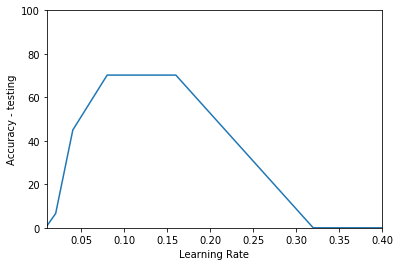

In [48]:
plt.plot(learnin, accuracytest)
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy - testing")
plt.axis([0.01, 0.40, 0, 100])
plt.show()

In [64]:
W_Now        = np.dot(220, W)
La           = 5
learningRate = 0.01
L_Erms_Val   = []
L_Erms_TR    = []
L_Erms_Test  = []
W_Mat        = []


accuracytra = []  #additional arrays are declared in order to save the results for each learning rate with the help of a while loop.
accuracyval = []
accuracytest = []
learnin=[]
#varying learning rate 10 times to get different error values and accuracies for different values of learning rate.

for i in range(0,100):
        
    #print ('---------Iteration: ' + str(i) + '--------------')
    Delta_E_D     = -np.dot((TrainingTarget[i] - np.dot(np.transpose(W_Now),TRAINING_PHI[i])),TRAINING_PHI[i])
    La_Delta_E_W  = np.dot(La,W_Now)
    Delta_E       = np.add(Delta_E_D,La_Delta_E_W)    
    Delta_W       = -np.dot(learningRate,Delta_E)
    W_T_Next      = W_Now + Delta_W
    W_Now         = W_T_Next
    
    #-----------------TrainingData Accuracy---------------------#
    TR_TEST_OUT   = GetValTest(TRAINING_PHI,W_T_Next) 
    Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget)
    L_Erms_TR.append(float(Erms_TR.split(',')[1]))
        
    
    #-----------------ValidationData Accuracy---------------------#
    VAL_TEST_OUT  = GetValTest(VAL_PHI,W_T_Next) 
    Erms_Val      = GetErms(VAL_TEST_OUT,ValDataAct)
    L_Erms_Val.append(float(Erms_Val.split(',')[1]))
       
    #-----------------TestingData Accuracy---------------------#
    TEST_OUT      = GetValTest(TEST_PHI,W_T_Next) 
    Erms_Test = GetErms(TEST_OUT,TestDataAct)
    L_Erms_Test.append(float(Erms_Test.split(',')[1]))
       
    

    accuracytra.append(float(Erms_TR.split(',')[0]))
    accuracyval.append(float(Erms_Val.split(',')[0]))
    accuracytest.append(float(Erms_Test.split(',')[0]))    
    #print ("E_rms Training   = " + str(np.around(min(L_Erms_TR),5)))
    #print ("E_rms Validation = " + str(np.around(min(L_Erms_Val),5)))
    #print ("E_rms Testing    = " + str(np.around(min(L_Erms_Test),5)))
    
    
   

0.01
0.02
0.04
0.08


OverflowError: math range error

In [ ]:
plt.plot(learnin, accuracytest)
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy - testing")
plt.show()